# Surrogate (snntorch) vs Eventprop Comparison

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

from yingyang.dataset import YinYangDataset

import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import argparse

In [2]:
%load_ext autoreload
%autoreload 2

## Data and Config

In [3]:
from eventprop.config import get_flat_dict_from_nested

In [4]:
data_config = {
    "seed": 42,
    "dataset": "ying_yang",
    "deterministic": True,
    "batch_size": 32,
    "encoding": "latency",
    "T": 30,
    "dt": 1e-3,
    "t_min": 2,
    "data_folder": "../../../data/",
}

In [5]:
torch.manual_seed(data_config["seed"])
np.random.seed(data_config["seed"])
random.seed(data_config["seed"])

data_config["dataset"] = data_config["dataset"]
if data_config["deterministic"]:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

if data_config["dataset"] == "mnist":
    train_dataset = datasets.MNIST(
        data_config["data_folder"],
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    )
    test_dataset = datasets.MNIST(
        data_config["data_folder"],
        train=False,
        download=True,
        transform=transforms.ToTensor(),
    )
elif data_config["dataset"] == "ying_yang":
    train_dataset = YinYangDataset(size=1000, seed=data_config["seed"])
    test_dataset = YinYangDataset(size=1000, seed=data_config["seed"] + 2)

elif data_config["dataset"] == "synthetic":
    in_dim = 2
    input_spike_times = {
        k: (
            np.random.choice(np.arange(int(data_config["T"]) - 1), size=5)
            * (1e-3 / data_config["dt"])
        ).astype(int)
        for k in range(in_dim)
    }
    input_spikes = np.zeros((data_config["T"], 1, in_dim))
    for n, times in input_spike_times.items():
        input_spikes[times, 0, n] = 1

else:
    raise ValueError("Invalid dataset name")

if data_config["dataset"] != "synthetic":
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=data_config["batch_size"],
        shuffle=True,
        drop_last=True,
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=data_config["batch_size"],
        shuffle=False,
        drop_last=True,
    )

In [6]:
data, target = next(iter(train_loader))

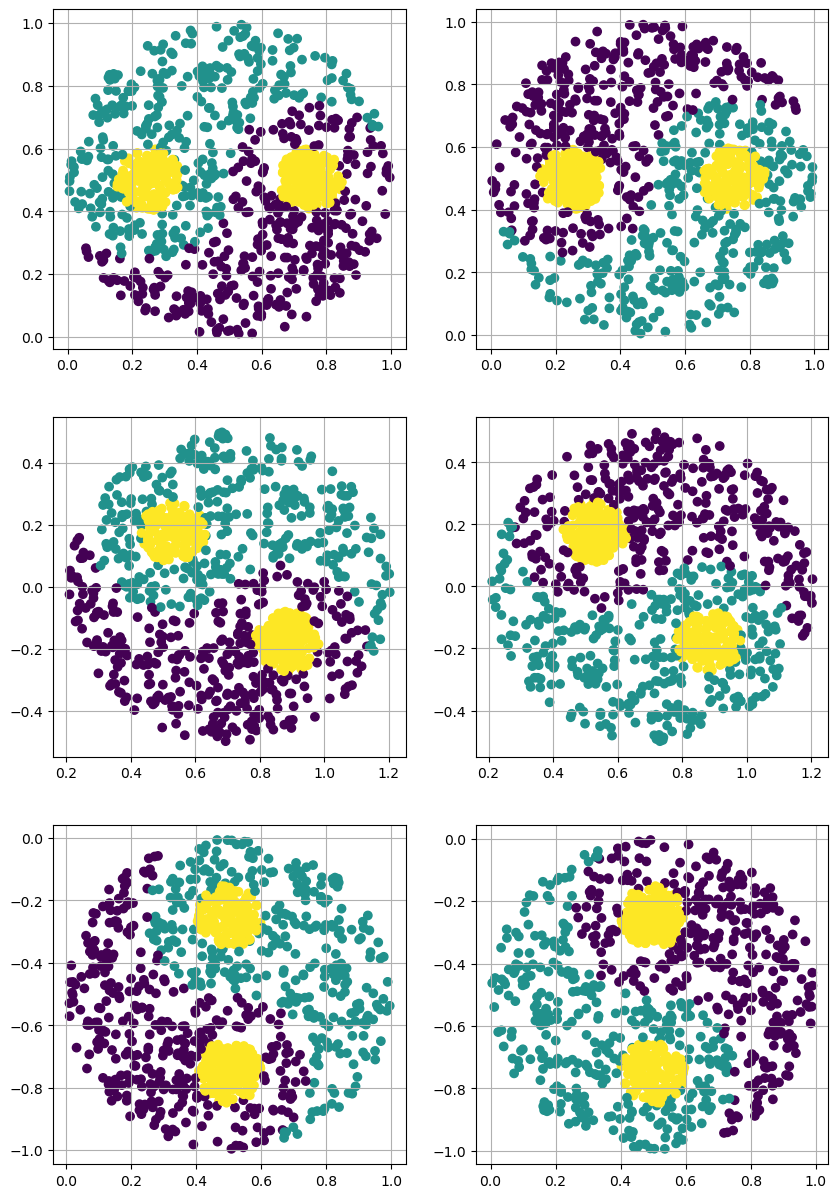

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for r_axs, r in zip(axs, [0, 45, 90]):
    train_dataset = YinYangDataset(
        size=1000, seed=data_config["seed"], rotation=np.deg2rad(r)
    )
    for i, ax in enumerate(r_axs):
        data = train_dataset.data[:, 2 * i : 2 * i + 2]
        ax.scatter(data[:, 0], data[:, 1], c=train_dataset.targets)
        # ax.axis("off")
        ax.grid(True)

In [48]:
rotation_matrix.shape

(2, 4)

In [41]:
train_dataset.data[:, 2 * i : 2 * i + 2].shape

(1000, 2)

In [30]:
r = 90
rotation_matrix = np.array(
    [
        [np.cos(np.deg2rad(r)), -np.sin(np.deg2rad(r))],
        [np.sin(np.deg2rad(r)), np.cos(np.deg2rad(r))],
    ]
)

In [36]:
(train_dataset.data[:, :2] @ rotation_matrix)

(1000, 2)

## Models

In [6]:
from eventprop.models import SNN

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
paper_params = {
    "mnist": {
        "mu": [0.078, 0.2],
        "sigma": [0.045, 0.37],
    },
    "ying_yang": {
        "mu": [1.5, 0.93],
        "sigma": [0.78, 0.1],
    },
}

model_config = {
    "model_type": "eventprop",
    "snn": {
        "T": data_config["T"],
        "dt": data_config["dt"],
        "tau_m": 20e-3,
        "tau_s": 5e-3,
    },
    "weights": {
        "init_mode": "normal",
        "scale": 5,
        "mu": paper_params[data_config["dataset"]]["mu"],
        "sigma": paper_params[data_config["dataset"]]["sigma"],
        "n_hid": 200,
        "resolve_silent": False,
        "dropout": 0.0,
    },
    "device": (
        torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ),
}

training_config = {
    "n_epochs": 50,
    "loss": "ce_temporal",
    "alpha": 3e-3,
    "xi": 0.5,
    "beta": 6.4,
    "n_tests": 1,
}

optim_config = {
    "lr": 5e-3,
    "weight_decay": 0.0,
    "optimizer": "adam",
    "gamma": 0.95,
}

config = {
    "data": data_config,
    "model": model_config,
    "training": training_config,
    "optim": optim_config,
}

flat_config = get_flat_dict_from_nested(config)

n_ins = {
    "mnist": 784,
    "ying_yang": 5 if data_config["encoding"] == "latency" else 4,
    "synthetic": 2,
}
n_outs = {"mnist": 10, "ying_yang": 3, "synthetic": 2}

dims = [n_ins[data_config["dataset"]]]
if model_config["weights"]["n_hid"] is not None and isinstance(
    model_config["weights"]["n_hid"], list
):
    dims.extend(model_config["weights"]["n_hid"])
elif isinstance(model_config["weights"]["n_hid"], int):
    dims.append(model_config["weights"]["n_hid"])
dims.append(n_outs[data_config["dataset"]])

In [9]:
snntorch_model = SNN(dims, **dict(flat_config, model_type="snntorch")).to(device)
eventprop_model = SNN(dims, **dict(flat_config, model_type="eventprop")).to(device)

for l, (layer1, layer2) in enumerate(
    zip(eventprop_model.layers, snntorch_model.layers)
):
    if data_config["dataset"] == "synthetic":
        n2, n1 = layer1.weight.data.shape
        nu = 1 / np.sqrt(n1)
        layer1.weight.data = (
            torch.from_numpy(
                np.random.normal(nu, nu, size=(n1, n2))
                * model_config["weights"]["scale"][l]
            )
            .T.to(device)
            .float()
        )
        # layer1.weight.data =  (torch.arange(1, n1 * n2 + 1).reshape((n1, n2)) + l * n1 * n2).float().to(device)

    layer2.weight.data = layer1.weight.data

    if hasattr(layer1, "bias"):
        layer2.bias.data = layer1.bias.data
models = {"snntorch": snntorch_model, "eventprop": eventprop_model}

Creating Spiking Linear with 5 -> 200
Creating Spiking Linear with 200 -> 3


## Behavior Comparison

In [10]:
from eventprop.training import encode_data

### Voltage plot check

In [11]:
if True:
    if data_config["dataset"] == "synthetic":
        in_spikes = torch.from_numpy(input_spikes).float().to(device)
        targets = torch.tensor([0])
    else:
        data, targets = next(iter(test_loader))
        data, targets = data.to(device), targets.to(device)
        in_spikes = encode_data(data, argparse.Namespace(**data_config))

    outs = {n: model(in_spikes) for n, model in models.items()}

In [12]:
from eventprop.models import SpikeCELoss

loss_fn = SpikeCELoss(xi=0.5)

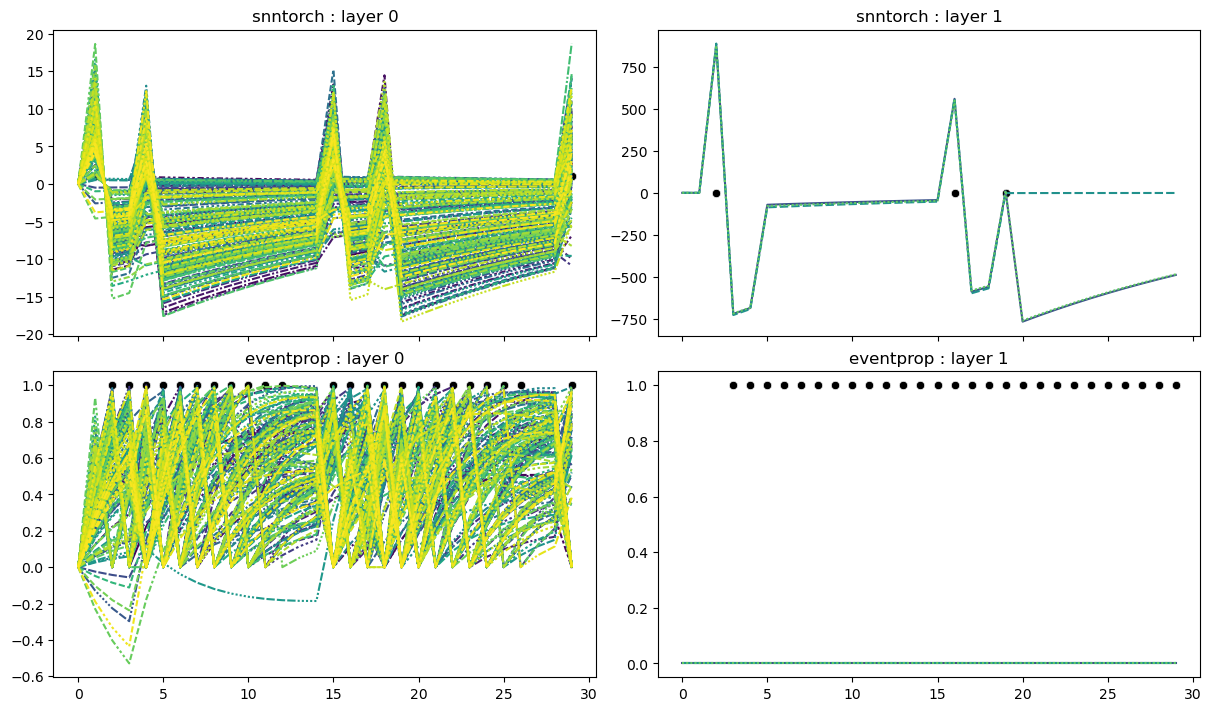

In [13]:
n_layers = len(models["eventprop"].layers)
fig, axs = plt.subplots(
    n_layers,
    2,
    figsize=(12, 3.5 * n_layers),
    sharex=True,
    sharey=False,
    constrained_layout=True,
)
try:
    axs[0]
except TypeError:
    axs = np.array(axs)[None, :]
try:
    axs[0][0]
except TypeError:
    axs = np.array(axs)[:, None]


for ax_model, (name, out) in zip(axs, outs.items()):
    for l, ax in enumerate(ax_model):
        voltages = out[1]["V"][l][:, 0].cpu().detach().numpy()
        out_spikes = out[1]["spikes"][l][:, 0].cpu().detach().numpy()
        sns.lineplot(voltages, palette="viridis", ax=ax)
        sns.scatterplot(
            x=np.where(out_spikes)[0],
            y=np.ones_like(np.where(out_spikes)[0]),
            ax=ax,
            color="black",
        )
        ax.set_title(f"{name} : layer {l}")
        ax.legend().remove()

In [17]:
raise KeyboardInterrupt

KeyboardInterrupt: 

### Firing rates check

In [ ]:
if False:
    counts = [0, 0]
    frs = [0, 0]
    n_batch = len(train_loader)
    for (data, target), _ in zip(tqdm(train_loader, total=n_batch), range(n_batch)):
        data, target = data.to(device), target.to(device)
        spikes_data = encode_data(data, data_config)
        snn_out = models["snntorch"](spikes_data)
        event_out = models["eventprop"](spikes_data)
        counts = [
            c + out[0].unique(return_counts=True)[1]
            for c, out in zip(counts, [snn_out, event_out])
        ]
        for f, s in enumerate([snn_out, event_out]):
            frs[f] += s[0].float().sum(0).mean(0)
    frs = torch.stack(frs) / n_batch
    frs, counts

In [ ]:
raise KeyboardInterrupt

KeyboardInterrupt: 

## Training

In [ ]:
from eventprop.training import train_single_model, test
from snntorch.functional.loss import (
    ce_temporal_loss,
    SpikeTime,
    ce_rate_loss,
    ce_count_loss,
)

In [ ]:
first_spike_fn = SpikeTime().first_spike_fn
training_config = {
    "n_epochs": 2,
    "loss": "ce_temporal",
    "first_spike_fn": first_spike_fn,
    "alpha": 0.0,
}

optim_config = {"lr": 1e-3, "weight_decay": 0, "optimizer": "adam"}

optimizers_type = {"adam": torch.optim.Adam, "sgd": torch.optim.SGD}
optimizers = {
    n: optimizers_type[optim_config["optimizer"]](
        model.parameters(),
        lr=optim_config["lr"],
        weight_decay=optim_config["weight_decay"],
    )
    for n, model in models.items()
}

In [ ]:
def get_flat_dict_from_nested(config):
    flat_dict = {}
    for key, value in config.items():
        if isinstance(value, dict):
            flat_dict.update(get_flat_dict_from_nested(value))
        else:
            flat_dict[key] = value
    return flat_dict

In [ ]:
config = {
    "data": data_config,
    "model": model_config,
    "training": training_config,
    "optim": optim_config,
}
flat_config = get_flat_dict_from_nested(config)

In [ ]:
args = argparse.Namespace(**flat_config)

In [ ]:
loaders = {"train": train_loader, "test": test_loader}

if args.loss == "ce_temporal":
    criterion = ce_temporal_loss()
elif args.loss == "ce_rate":
    criterion = ce_rate_loss()
elif args.loss == "ce_count":
    criterion = ce_count_loss()
else:
    raise ValueError("Invalid loss type")

In [ ]:
train_results = {
    n: train_single_model(
        model,
        criterion,
        optimizers[n],
        loaders,
        args,
        first_spike_fn=first_spike_fn,
        use_wandb=False,
    )
    for n, model in models.items()
}

|:   0%|          | 0/2 [00:00<?, ?it/s]

|:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import wandb

In [ ]:
wandb.run.id

'u3rvbc03'

In [ ]:
from itertools import product

In [ ]:
plot_data = {}
for name, results in train_results.items():
    for trial, metric in product(["train", "test"], ["loss", "acc"]):
        plot_data.setdefault(f"{trial}_{metric}", [])
        plot_data[f"{trial}_{metric}"].extend(results[f"{trial}_{metric}"])
    plot_data.setdefault("epoch", [])
    plot_data["epoch"].extend(np.arange(len(results[f"{trial}_{metric}"])))
    plot_data.setdefault("model", [])
    plot_data["model"].extend([name] * len(results[f"{trial}_{metric}"]))

In [ ]:
plot_data

NameError: name 'plot_data' is not defined

### Initialization

In [ ]:
from eventprop.initalization import FluctuationDrivenCenteredNormalInitializer

In [ ]:
paper_params = {
    "mnist": {
        "mu": [0.078, 0.2],
        "sigma": [0.045, 0.37],
    },
    "ying_yang": {"mu": [1.5, 0.78], "sigma": [0.93, 0.1]},
}
k_aiming_params = {"mu": [0, 0], "sigma": [1 / np.sqrt(d) for d in dims[:-1]]}

dt, T = data_config["dt"], data_config["T"]

xi = 3
sigma_nu, nu = 1 / xi, 15

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_nu, nu=nu, timestep=dt
)

fluctuation_params = {
    name: {
        k: v
        for k, v in zip(
            ["mu", "sigma"],
            list(
                zip(
                    *[
                        initializer._get_weight_parameters_con(layer)
                        for layer in model.cpu().layers
                    ]
                )
            ),
        )
    }
    for name, model in models.items()
}
paper_params[data_config["dataset"]], fluctuation_params["eventprop"], k_aiming_params

KeyError: 'synthetic'